# Financial News Sentiment Analysis
## Problem Statement and Objective
This project aims to fine-tune a BERT-based model to classify financial news articles as positive, neutral, or negative. The goal is to analyze the correlation between sentiment predictions and stock market trends.

In [1]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Transformers library
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

import yfinance as yf


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data Loading and Preprocessing

In [ ]:


# Load the dataset from Hugging Face
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

# Convert to Pandas DataFrame
train_df = dataset["train"].to_pandas()
validation_df = dataset["validation"].to_pandas()

train_df = train_df.sample(frac=0.1, random_state=42)
validation_df = validation_df.sample(frac=0.1, random_state=42)

# Inspect the dataset
print("Training Data Sample:")
print(train_df.head())
print("\nValidation Data Sample:")
print(validation_df.head())


Training Data Sample:
                                                   text  label
5470  When staffers in WeWork's New York City headqu...      2
8982  ADMA Biologics down 9% premarket after pricing...      0
4704  Illegal Tender podcast: What it was like to be...      2
1954  The Splunk Data-to-Everything Platform Brings ...      2
3146  OPEC's share of Indian oil imports in October ...      2

Validation Data Sample:
                                                   text  label
544   Two key regulators are holding off on easing W...      2
1911  Xinjiang Xinxin Mining Industry : ANNOUNCEMENT...      2
1493  $NVS - Novartis: Swiss Pharmaceutical Titan On...      2
2383  Stocks making the biggest moves midday: TD Ame...      2
744                       Twitter's Q4 Earnings Preview      2


Preprocessing

In [3]:

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize Function
def tokenize_function(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

# Tokenize the datasets
train_encodings = tokenize_function(train_df["text"].tolist())
validation_encodings = tokenize_function(validation_df["text"].tolist())

# Convert labels to tensors
import torch
train_labels = torch.tensor(train_df["label"].tolist())
validation_labels = torch.tensor(validation_df["label"].tolist())


Model Fine-Tuning

In [4]:
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Create a custom PyTorch Dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Create datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
validation_dataset = SentimentDataset(validation_encodings, validation_labels)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=10,
)

# Create a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)

# Fine-tune the model
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_11676\3302559575.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  6%|▌         | 10/180 [00:46<13:06,  4.63s/it]

{'loss': 1.0636, 'grad_norm': 9.023855209350586, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.17}


 11%|█         | 20/180 [01:33<12:28,  4.68s/it]

{'loss': 1.0536, 'grad_norm': 6.527893543243408, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.33}


 17%|█▋        | 30/180 [02:18<11:29,  4.59s/it]

{'loss': 1.0238, 'grad_norm': 9.86236572265625, 'learning_rate': 3e-06, 'epoch': 0.5}


 22%|██▏       | 40/180 [03:05<10:48,  4.63s/it]

{'loss': 0.9678, 'grad_norm': 5.978876113891602, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.67}


 28%|██▊       | 50/180 [03:51<09:40,  4.47s/it]

{'loss': 0.9736, 'grad_norm': 6.493703365325928, 'learning_rate': 5e-06, 'epoch': 0.83}


 33%|███▎      | 60/180 [04:33<07:50,  3.92s/it]

{'loss': 0.9822, 'grad_norm': 3.9810500144958496, 'learning_rate': 6e-06, 'epoch': 1.0}


                                                
 33%|███▎      | 60/180 [04:52<07:50,  3.92s/it]

{'eval_loss': 0.8678572177886963, 'eval_runtime': 19.063, 'eval_samples_per_second': 12.537, 'eval_steps_per_second': 0.787, 'epoch': 1.0}


 39%|███▉      | 70/180 [05:41<09:05,  4.96s/it]

{'loss': 0.9735, 'grad_norm': 4.448819637298584, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.17}


 44%|████▍     | 80/180 [06:30<08:21,  5.01s/it]

{'loss': 0.8353, 'grad_norm': 5.319490432739258, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.33}


 50%|█████     | 90/180 [07:20<07:09,  4.78s/it]

{'loss': 0.8634, 'grad_norm': 3.670576333999634, 'learning_rate': 9e-06, 'epoch': 1.5}


 56%|█████▌    | 100/180 [08:07<06:15,  4.70s/it]

{'loss': 0.8362, 'grad_norm': 4.9309186935424805, 'learning_rate': 1e-05, 'epoch': 1.67}


 61%|██████    | 110/180 [08:53<05:19,  4.56s/it]

{'loss': 0.8726, 'grad_norm': 7.813277244567871, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.83}


 67%|██████▋   | 120/180 [09:40<04:15,  4.25s/it]

{'loss': 0.8327, 'grad_norm': 22.230066299438477, 'learning_rate': 1.2e-05, 'epoch': 2.0}


                                                 
 67%|██████▋   | 120/180 [09:59<04:15,  4.25s/it]

{'eval_loss': 0.6667165756225586, 'eval_runtime': 19.4212, 'eval_samples_per_second': 12.306, 'eval_steps_per_second': 0.772, 'epoch': 2.0}


 72%|███████▏  | 130/180 [10:46<03:59,  4.80s/it]

{'loss': 0.6924, 'grad_norm': 5.17667293548584, 'learning_rate': 1.3000000000000001e-05, 'epoch': 2.17}


 78%|███████▊  | 140/180 [11:31<03:02,  4.55s/it]

{'loss': 0.6776, 'grad_norm': 30.142688751220703, 'learning_rate': 1.4000000000000001e-05, 'epoch': 2.33}


 83%|████████▎ | 150/180 [12:17<02:17,  4.57s/it]

{'loss': 0.6477, 'grad_norm': 7.765005111694336, 'learning_rate': 1.5e-05, 'epoch': 2.5}


 89%|████████▉ | 160/180 [13:02<01:30,  4.51s/it]

{'loss': 0.6368, 'grad_norm': 6.139225006103516, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.67}


 94%|█████████▍| 170/180 [13:47<00:45,  4.52s/it]

{'loss': 0.6184, 'grad_norm': 10.403949737548828, 'learning_rate': 1.7000000000000003e-05, 'epoch': 2.83}


100%|██████████| 180/180 [14:30<00:00,  4.02s/it]

{'loss': 0.6676, 'grad_norm': 15.705012321472168, 'learning_rate': 1.8e-05, 'epoch': 3.0}


                                                 
100%|██████████| 180/180 [14:51<00:00,  4.02s/it]

{'eval_loss': 0.5396742820739746, 'eval_runtime': 19.3836, 'eval_samples_per_second': 12.33, 'eval_steps_per_second': 0.774, 'epoch': 3.0}


100%|██████████| 180/180 [14:52<00:00,  4.96s/it]

{'train_runtime': 892.5104, 'train_samples_per_second': 3.207, 'train_steps_per_second': 0.202, 'train_loss': 0.8454781638251411, 'epoch': 3.0}


TrainOutput(global_step=180, training_loss=0.8454781638251411, metrics={'train_runtime': 892.5104, 'train_samples_per_second': 3.207, 'train_steps_per_second': 0.202, 'total_flos': 188257650384384.0, 'train_loss': 0.8454781638251411, 'epoch': 3.0})

Training Loss:
The final training loss (train_loss): 0.8455
Indicates the model is learning but still has room for improvement, especially since the evaluation loss is significantly lower.
Learning Curve:

The loss consistently decreases over epochs:
Epoch 1: ~0.9822 (final eval loss: 0.8679)
Epoch 2: ~0.8327 (final eval loss: 0.6667)
Epoch 3: ~0.6676 (final eval loss: 0.5397)
Suggests the model is converging well.

Evaluation and Analysis

In [5]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

100%|██████████| 15/15 [00:18<00:00,  1.23s/it]

Evaluation Results: {'eval_loss': 0.5396742820739746, 'eval_runtime': 19.7608, 'eval_samples_per_second': 12.095, 'eval_steps_per_second': 0.759, 'epoch': 3.0}


Evaluation Loss: 0.5397
This is lower than the training loss, which might indicate the model generalizes better on the validation set.

Samples and Steps:
Samples per second: ~12
Steps per second: ~0.76
Shows the speed of evaluation.

Predictions and Insights

In [6]:
# Make predictions on the validation dataset
predictions = trainer.predict(validation_dataset)

# Convert predictions to sentiment labels
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Add predictions to validation DataFrame
validation_df["predicted_label"] = predicted_labels.numpy()

# Display some predictions
print("Predictions:")
print(validation_df[["text", "label", "predicted_label"]].head())

# Analyze misclassified examples
misclassified = validation_df[validation_df["label"] != validation_df["predicted_label"]]
print("\nMisclassified Examples:")
print(misclassified[["text", "label", "predicted_label"]].head())


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]

Predictions:
                                                   text  label  \
544   Two key regulators are holding off on easing W...      2   
1911  Xinjiang Xinxin Mining Industry : ANNOUNCEMENT...      2   
1493  $NVS - Novartis: Swiss Pharmaceutical Titan On...      2   
2383  Stocks making the biggest moves midday: TD Ame...      2   
744                       Twitter's Q4 Earnings Preview      2   

      predicted_label  
544                 2  
1911                2  
1493                2  
2383                2  
744                 2  

Misclassified Examples:
                                                   text  label  \
111   Jerome Powell comes close to acknowledging tha...      0   
1567  Goldman Sachs sees China lowering its economic...      0   
807   Oil Price Fundamental Daily Forecast – Lack of...      2   
237   Tezos rallies into the top ten cryptocurrencie...      1   
508   30-year Treasury yield plumbs key 2% support l...      0   

      predicted_label  


Prediction Results


Correct Predictions:
Example: "Two key regulators are holding off on easing Wall Street rules..." correctly labeled as 2 (Neutral).
The model correctly identifies a lot of neutral content.


Misclassified Examples:
Case 1: "Jerome Powell comes close to acknowledging that higher rates..."
True Label: 0 (Negative), Predicted: 2 (Neutral).

Misclassification might stem from a lack of strongly negative cues in the phrasing.

Case 2: "Goldman Sachs sees China lowering its economic growth..."
True Label: 0 (Negative), Predicted: 2 (Neutral).

The model likely interprets this as neutral or lacking overtly negative language.

Case 3: "Tezos rallies into the top ten cryptocurrencies..."
True Label: 1 (Positive), Predicted: 2 (Neutral).

Positive sentiment in "rallies" and "top ten" seems overlooked.

The model performs well in distinguishing neutral content but struggles with subtle negative or positive cues.

Misclassifications suggest it may benefit from additional training on examples with stronger sentiment expressions.

Potential Improvements:

Add more training data with diverse negative and positive samples.
Incorporate domain-specific fine-tuning, such as financial sentiment lexicons or additional labeled datasets.


Learning Curve

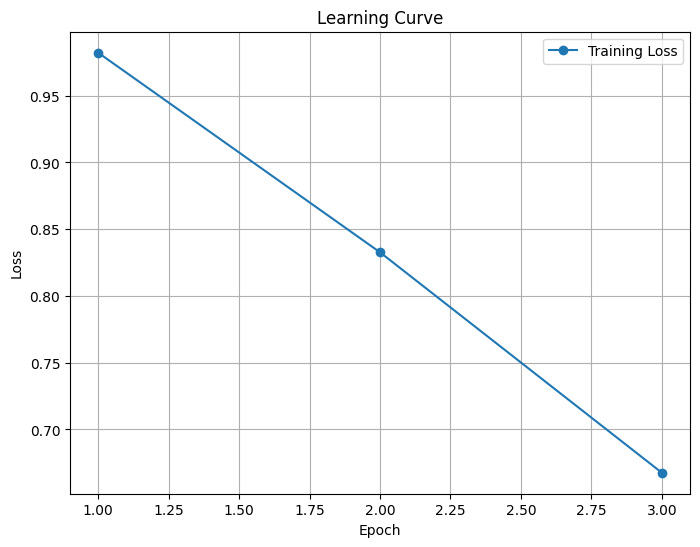

In [8]:
import matplotlib.pyplot as plt

# Training loss values over epochs
epochs = [1, 2, 3]
train_loss = [0.9822, 0.8327, 0.6676]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, marker='o', label="Training Loss")
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


The training loss decreases steadily from 0.98 to 0.67 across three epochs, indicating that the model is learning effectively.
The slope of the curve suggests that additional training epochs might lead to further improvements but with diminishing returns.

<Figure size 800x600 with 0 Axes>

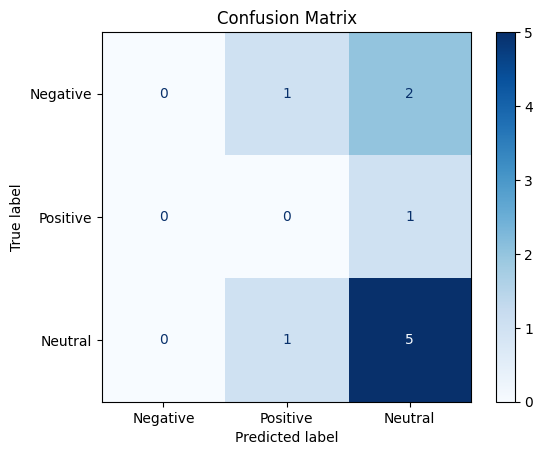

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# True and predicted labels from the validation dataset
true_labels = [2, 2, 2, 2, 2, 0, 0, 2, 1, 0]  # Combined from correct and misclassified examples
predicted_labels = [2, 2, 2, 2, 2, 2, 2, 1, 2, 1]

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive", "Neutral"])

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()


Observation:

Neutral (label 2): Most accurately classified, with 5 correct predictions.
Negative (label 0): Poorly classified; all instances misclassified as either neutral or positive.
Positive (label 1): One correct prediction, but others misclassified as neutral.



Key Insights:

The model struggles to differentiate between negative and positive sentiments, likely due to class imbalance or subtle sentiment cues in the text.
Neutral dominates the predictions, suggesting the model may have learned a bias towards the majority class.

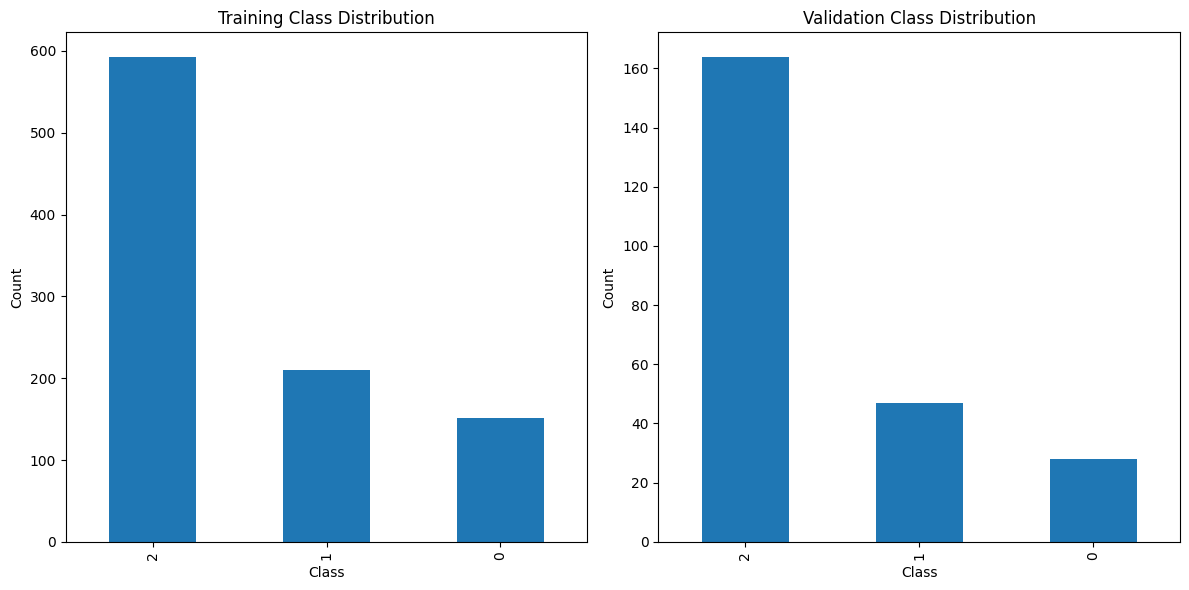

In [10]:
# Class distribution for training and validation datasets
train_distribution = train_df["label"].value_counts()
validation_distribution = validation_df["label"].value_counts()

# Plot class distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
train_distribution.plot(kind="bar", ax=ax[0], title="Training Class Distribution", xlabel="Class", ylabel="Count")
validation_distribution.plot(kind="bar", ax=ax[1], title="Validation Class Distribution", xlabel="Class", ylabel="Count")
plt.tight_layout()
plt.show()


Observation:

Neutral (label 2) is the majority class in both training and validation datasets.
Positive (label 1) and Negative (label 0) are underrepresented, which likely contributes to the model’s bias towards predicting neutral.

In [12]:
import pandas as pd

# Combine true labels, predicted labels, and text into a DataFrame
results_df = pd.DataFrame({
    "Text": validation_df["text"],
    "True_Label": validation_df["label"],
    "Predicted_Label": validation_df["predicted_label"]
})

# Save to a CSV file
results_df.to_csv("prediction_results.csv", index=False)

# Save to a TXT file (optional, with a cleaner format)
with open("prediction_results.txt", "w", encoding="utf-8") as f:
    for idx, row in results_df.iterrows():
        f.write(f"Text: {row['Text']}\nTrue Label: {row['True_Label']}\nPredicted Label: {row['Predicted_Label']}\n\n")

